## Imports

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

from os import walk
from os.path import join

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

%matplotlib inline

## Constants

In [244]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH =  "SpamData/01_Processing/spam_assassin_corpus/spam_1"
SPAM_2_PATH =  "SpamData/01_Processing/spam_assassin_corpus/spam_2"
EASY_NONSPAM_1_PATH =  "SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
EASY_NONSPAM_2_PATH =  "SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = "SpamData/01_Processing/email-text-data.json"
WORD_ID_FILE = "SpamData/01_Processing/word-by-id.csv"

TRAINING_DATA_FILE = "SpamData/02_Training/train-data.txt"
TEST_DATA_FILE = "SpamData/02_Training/test-data.txt"

WHALE_FILE = "SpamData/01_Processing/wordcloud_resources/whale-icon.png"
SKULL_FILE = "SpamData/01_Processing/wordcloud_resources/skull-icon.png"
THUMBS_UP = "SpamData/01_Processing/wordcloud_resources/thumbs-up.png"
THUMBS_DOWN = "SpamData/01_Processing/wordcloud_resources/thumbs-down.png"
CUSTOM_FONT_FILE = "SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf"

## Reading Fİles

In [121]:
stream = open(EXAMPLE_FILE, encoding="latin-1")
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [122]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Email Body Extraction

In [123]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            yield file_name, email_body

In [124]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [125]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.describe

<bound method NDFrame.describe of                                                                                   MESSAGE  \
00001.7848dde101aa985090474a91ec93fcf0  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...   
00002.d94f1b97e48ed3b553b3508d116e6a09  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
00003.2ee33bc6eacdb11f38d052c44819ba6c  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
00004.eac8de8d759b7e74154f142194282724  ##############################################...   
00005.57696a39d7d84318ce497886896bf90d  I thought you might like these:\n\n1) Slim Dow...   
...                                                                                   ...   
01397.f75f0dd0dd923faefa3e9cc5ecb8c906  This is a multi-part message in MIME format.\n...   
01398.8ca7045aae4184d56e8509dc5ad6d979  Dear Subscriber,\n\n\n\nIf I could show you a ...   
01399.2319643317e2c5193d574e40a71809c2  ****Mid-Summer Customer Appreciation SALE!****...   
01400.b444b69845db2fa0a4693ca04e6ac5

In [126]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

(3901, 2)

In [127]:
data= pd.concat([spam_emails, ham_emails])
print("Shape of dataframe is", data.shape)
data

Shape of dataframe is (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1
...,...,...
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0


## Data Cleaning

In [128]:
data.MESSAGE.isnull().values.any()

False

In [129]:
data.MESSAGE.isnull().sum()

0

In [130]:
(data.MESSAGE.str.len()== 0).any()

True

In [131]:
(data.MESSAGE.str.len()== 0).sum()

3

### Find Empty emails

In [132]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [133]:
data.index.get_loc("cmds")

array([False, False, False, ..., False, False, False])

## Remove Files From Dataframe

In [134]:
data.drop(["cmds"], inplace= True)
data[data.MESSAGE.str.len() == 0].index

Index([], dtype='object')

In [135]:
data.shape

(5796, 2)

## Add Document ID

In [136]:
document_ids= range(0,len(data.index))
data["DOC_ID"] = document_ids

In [137]:
data["FILE_NAME"] = data.index
data.set_index('DOC_ID', inplace=True)
data

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d
...,...,...,...
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676


## Save to File using Pandas

In [138]:
data.to_json(DATA_JSON_FILE)

## Visualisation

In [139]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [140]:
amounth_of_spam = data.CATEGORY.value_counts()[1]
amounth_of_ham = data.CATEGORY.value_counts()[0]

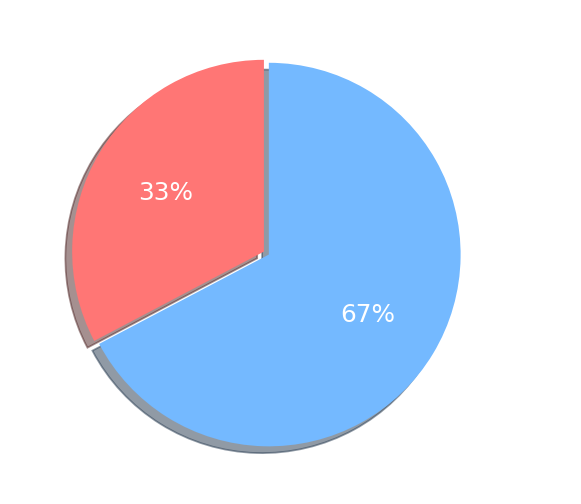

In [141]:
category_names = ["Spam","Legit Mail"]
sizes = [amounth_of_spam, amounth_of_ham]
custom_color= ["#ff7675", "#74b9ff"]

plt.figure(figsize=(5,5), dpi = 127)
plt.pie(sizes, labels=category_names, textprops= {"fontsize": 14, "color":"white"}, shadow= True,
startangle= 90, autopct= "%1.0f%%", colors= custom_color, explode= [0,0.03])
plt.show()

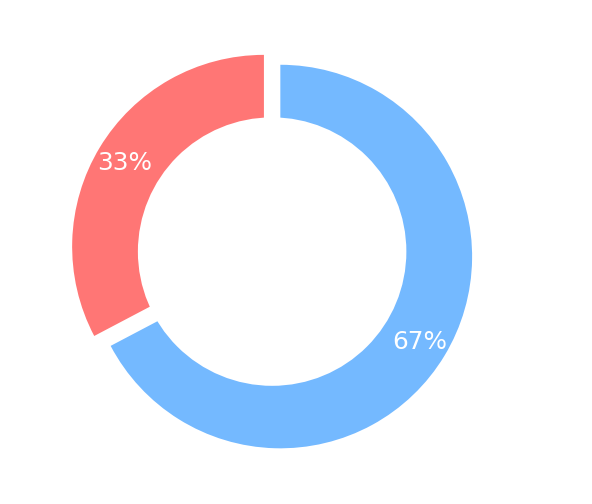

In [142]:
category_names = ["Spam","Legit Mail"]
sizes = [amounth_of_spam, amounth_of_ham]
custom_color= ["#ff7675", "#74b9ff"]
offset= [0.05,0.05]

plt.figure(figsize=(5,5), dpi = 127)
plt.pie(sizes, labels=category_names, textprops= {"fontsize": 14, "color":"white"}, shadow= False,
startangle= 90, autopct= "%1.0f%%", colors= custom_color, pctdistance= 0.85,explode= offset)

center_circle = plt.Circle((0,0), radius= 0.7, fc="white")
plt.gca().add_artist(center_circle)

plt.show()

## Natural Language Processing

### Download the resources

In [143]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mbatu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [144]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mbatu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Language Processing

In [145]:
stop_words = set(stopwords.words("english"))

In [146]:
msg = "Nobody expects the Spanish Inquisition.\
 All work and no play makes Jac ka dull boy. To be or not To be"
words = word_tokenize(msg.lower())


# stemmer = PorterStemmer()
stemmer = SnowballStemmer("english")

filtered = []

for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered.append(stemmed_word)
        
print(filtered)

['nobodi', 'expect', 'spanish', 'inquisit', '.', 'work', 'play', 'make', 'jac', 'ka', 'dull', 'boy', '.']


In [147]:
msg = "Nobody expects the Spanish Inquisition!.\
 All work and no play makes Jac ka dull boy. To be or not To be"
words = word_tokenize(msg.lower())


# stemmer = PorterStemmer()
stemmer = SnowballStemmer("english")

filtered = []

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered.append(stemmed_word)
        
print(filtered)

['nobodi', 'expect', 'spanish', 'inquisit', 'work', 'play', 'make', 'jac', 'ka', 'dull', 'boy']


In [148]:
soup = BeautifulSoup(data.at[2,"MESSAGE"], "html.parser")
print(soup.prettify())

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&amp;s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&amp;s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&amp;s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&amp;s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&amp;s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



## Function for email Precessing

In [149]:
def clean_message(message, stemmer= PorterStemmer(),
 stop_words = set(stopwords.words("english"))):

    words = word_tokenize(message.lower())

    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))


    return filtered_words

In [150]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [151]:
def clean_msg_no_html(message, stemmer= PorterStemmer(),
 stop_words = set(stopwords.words("english"))):

    soup = BeautifulSoup(message,"html.parser")
    cleaned_text = soup.get_text()

    words = word_tokenize(cleaned_text.lower())

    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            # filtered_words.append(stemmer.stem(word))
            filtered_words.append(word)


    return filtered_words

In [152]:
clean_msg_no_html(data.at[2,"MESSAGE"])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guaranteed',
 'lose',
 'lbs',
 'days',
 'http',
 'get',
 'child',
 'support',
 'deserve',
 'free',
 'legal',
 'advice',
 'http',
 'join',
 'web',
 'fastest',
 'growing',
 'singles',
 'community',
 'http',
 'start',
 'private',
 'photo',
 'album',
 'online',
 'http',
 'wonderful',
 'day',
 'offer',
 'manager',
 'prizemama',
 'wish',
 'leave',
 'list',
 'please',
 'use',
 'link',
 'http',
 'zzzz']

## Apply Cleaning and Tokenization to All Messages

### Slicing Data frane and Series & Creating Subsets

In [153]:
data.iat[2,2]

'00003.2ee33bc6eacdb11f38d052c44819ba6c'

In [154]:
data.iloc[0:4]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724


In [155]:
data.MESSAGE.iloc[9:12]

DOC_ID
9     Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...
10    Cellular Phone Accessories All At Below Wholes...
11    <table width="600" border="20" align="center" ...
Name: MESSAGE, dtype: object

In [156]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)

In [157]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)
# len(flat_list)

In [158]:
flat_list = [item for sublist in nested_list for item in sublist]
len(flat_list)

321

In [159]:
nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\mbatu\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [160]:
nested_list

DOC_ID
0       [save, life, insurance, spend, life, quote, sa...
1       [fight, risk, cancer, http, slim, guaranteed, ...
2       [fight, risk, cancer, http, slim, guaranteed, ...
3       [adult, club, offers, free, membership, instan...
4       [thought, might, like, slim, guaranteed, lose,...
                              ...                        
5791    [http, bizarre, collection, stuffed, animals, ...
5792    [careful, using, one, also, really, cute, thin...
5793    [sm, skip, montanaro, writes, jeremy, put, ano...
5794    [mark, hammond, like, given, zodb, sounding, a...
5795    [hi, probably, use, whatsoever, also, problem,...
Name: MESSAGE, Length: 5796, dtype: object

### Using Logic to Slice Dataframes

In [161]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [162]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

## Subsetting a Series with an Index

In [163]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_spam = nested_list.loc[doc_ids_spam]

In [164]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0]

30098

In [165]:
normal_words[:10]

http      6609
list      2662
one       2247
would     2003
get       1780
like      1729
use       1704
wrote     1679
new       1500
people    1458
dtype: int64

In [166]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spam_words = pd.Series(flat_list_spam).value_counts()

spam_words.shape[0]

18022

In [167]:
spam_words[:10]

http        2902
email       2775
free        2583
click       1945
please      1824
get         1710
business    1635
list        1549
money       1541
one         1504
dtype: int64

## Creating a Wordcloud

In [168]:
# word_cloud = WordCloud().generate(email_body)
# plt.imshow(word_cloud, interpolation = "bilinear")
# plt.axis("off")
# plt.show

In [169]:
# nltk.download("gutenberg")
# nltk.download("shakespeare")

In [170]:
example_corpus = nltk.corpus.gutenberg.words("melville-moby_dick.txt")
len(example_corpus)

260819

In [171]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [172]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [173]:
word_list = ["".join(word) for word in example_corpus]
novel_as_string = " ". join(word_list)

In [174]:
# Moby Dick
# 
# icon = Image.open(WHALE_FILE)
# image_mask = Image.new(mode = "RGB", size = icon.size, color= (255,255,255))
# image_mask.paste(icon,box = icon)
# rgb_array = np.array (image_mask)

# word_cloud = WordCloud(mask = rgb_array, background_color= "white", max_words=350, colormap= "plasma")
# word_cloud.generate(novel_as_string)

# plt.figure(figsize=[16,8])
# plt.imshow(word_cloud, interpolation = "bilinear")
# plt.axis("off")
# plt.show

In [175]:
# Hamlet Shakespeare
# 
# hamlet_corpus = nltk.corpus.gutenberg.words("shakespeare-hamlet.txt")
# word_list = ["".join(word for word in hamlet_corpus)]
# hamlet_as_string = " ".join(word_list)

# skull_icon = Image.open(SKULL_FILE)
# image_mask = Image.new(mode = "RGB", size = skull_icon.size, color = (255,255,255))
# image_mask.paste(skull_icon, box= skull_icon)
# rgb_array = np.array(image_mask)
# word_cloud = WordCloud(mask = rgb_array, background_color="white", colormap= "bone", max_words= 600)

# word_cloud.generate(hamlet_as_string)

# plt.figure(figsize = [16,16])
# plt.imshow(word_cloud,interpolation="bilinear")
# plt.axis("off")
# plt.show()

## Work Cloud of Ham and Spam Messages

<function matplotlib.pyplot.show(close=None, block=None)>

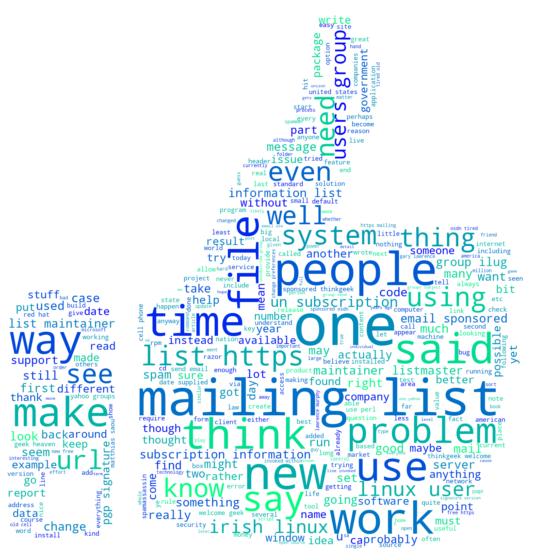

In [176]:
icon = Image.open(THUMBS_UP)
image_mask = Image.new(mode = "RGB", size = icon.size, color= (255,255,255))
image_mask.paste(icon,box = icon)
rgb_array = np.array (image_mask)

ham_str= " ".join(flat_list_ham)

word_cloud = WordCloud(mask = rgb_array, background_color= "white", 
 max_words=350, colormap= "winter")
word_cloud.generate(ham_str)

plt.figure(figsize=[10,10])
plt.imshow(word_cloud, interpolation = "bilinear")
plt.axis("off")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

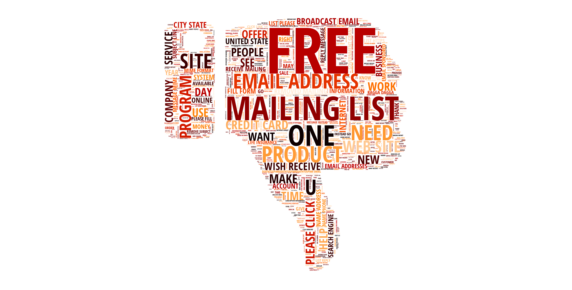

In [183]:
icon = Image.open(THUMBS_DOWN)
image_mask = Image.new(mode = "RGB", size = icon.size, color= (255,255,255))
image_mask.paste(icon,box = icon)
rgb_array = np.array (image_mask)

spam_str= " ".join(flat_list_spam)

word_cloud = WordCloud(mask = rgb_array, background_color= "white", max_font_size= 300, 
 max_words=1000, colormap= "gist_heat", font_path=CUSTOM_FONT_FILE)
word_cloud.generate(spam_str.upper())

plt.figure(figsize=[10,10])
plt.imshow(word_cloud, interpolation = "bilinear")
plt.axis("off")
plt.show

## Generate Vocabular & Dictionary

In [184]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list =[item for sublist in stemmed_nested_list for item in sublist]

C:\Users\mbatu\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [185]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print("Nr of unique words", unique_words.shape[0])
unique_words

Nr of unique words 38285


http             9511
list             4211
email            3995
one              3751
get              3490
                 ... 
latvia              1
lips                1
autogenerated       1
lecter              1
merde               1
Length: 38285, dtype: int64

In [190]:
frequent_words = unique_words[:VOCAB_SIZE]
frequent_words[0:10]

http           9511
list           4211
email          3995
one            3751
get            3490
free           3193
would          2746
people         2642
new            2624
information    2533
dtype: int64

## Create Vobulary DataFrame with a WORD_ID

In [195]:
word_ids= list(range(0,VOCAB_SIZE))
vocab= pd.DataFrame({"VOCAB_WORD":frequent_words.index.values}, index = word_ids)
vocab.index.name = "WORD_ID"
vocab

,VOCAB_WORD
WORD_ID,
0,http
1,list
2,email
3,one
4,get
...,...
2495,okay
2496,naturally
2497,citizen


## Save the Vocabulary as a CVS File

In [199]:
vocab.to_csv(WORD_ID_FILE, index_label = vocab.index.name, header= vocab.VOCAB_WORD.name)

In [205]:
#  clean_email_lengths = []

#  for sublist in stemmed_nested_list:
#      clean_email_lengths.append(len(sublist))

In [206]:
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print(" NR of words in the longest email: ", max(clean_email_lengths))

 NR of words in the longest email:  7671


In [207]:
print(" Email position in the list", np.argmax(clean_email_lengths))

 Email position in the list 5775


## Genarate Features & a Sparse Matrix

#### Creating a DataFrame with one Word per Column

In [208]:
type(stemmed_nested_list.tolist())

list

In [210]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())

#### Splitting the Data into a training and Testing Dataset

In [213]:
x_train , x_test, y_train, y_test = train_test_split(word_columns_df, 
 data.CATEGORY, test_size= 0.3, random_state=42)

In [215]:
print("NR of training samples", x_train.shape[0])
print("Fraction of training set", x_train.shape[0] / word_columns_df.shape[0])

NR of training samples 4057
Fraction of training set 0.6999654934437544


In [217]:
x_train.index.name = x_test.index.name = "DOC_ID"
x_train

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,yes,indeed,agents,directory,veritas,cd,unix,subdirectory,file,called,...,None,None,None,None,None,None,None,None,None,None
4727,problem,comes,try,install,harddissssk,like,already,mounted,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,original,message,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inline,folks,several,major,internet,outages,morning,across,major,providers,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicle,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,url,http,date,tue,sep,gmt,wired,urgent,business,proposition,...,None,None,None,None,None,None,None,None,None,None
5191,wandering,uppsala,sweden,last,week,ran,across,keramik,studio,paula,...,None,None,None,None,None,None,None,None,None,None
5226,pm,win,treese,wrote,actually,easy,test,experimentally,compare,results,...,None,None,None,None,None,None,None,None,None,None


In [218]:
y_train

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
       ..
3772    0
5191    0
5226    0
5390    0
860     1
Name: CATEGORY, Length: 4057, dtype: int64

## Create a sparse Matrix for the Training Data 

### Matrix Func

In [219]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [220]:
word_index.get_loc("thu")

597

In [223]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    returns sparse matrix as dataframe.

    df: a dataframe with words in the colummns with a domcument ıd as an index (x_train or x_test)
    indexed_words: index of word ordered word id
    labels: category as a series (y_train or y_test)
    """

    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []

    for i in range(nr_rows):
        for j in range(nr_cols):

            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]

                item = {"LABEL": category, "DOC_ID": doc_id, 
                 "OCCURENCE": 1, "WORD_ID": word_id}

                dict_list.append(item)

    return pd.DataFrame(dict_list)

In [224]:
sparse_train_df = make_sparse_matrix(x_train, word_index, y_train)

In [225]:
sparse_train_df

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,205
1,0,4844,1,1222
2,0,4844,1,1062
3,0,4844,1,343
4,0,4844,1,247
...,...,...,...,...
375656,1,860,1,382
375657,1,860,1,25
375658,1,860,1,111
375659,1,860,1,1170


### Combine Occurences with Pandas groupby() Method

In [227]:
trained_grouped = sparse_train_df.groupby(["DOC_ID","WORD_ID","LABEL"]).sum()

In [228]:
vocab.at[0,"VOCAB_WORD"]

'http'

In [230]:
trained_grouped = trained_grouped.reset_index()
trained_grouped

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,1,1,1
1,0,2,1,2
2,0,4,1,1
3,0,5,1,3
4,0,8,1,1
...,...,...,...,...
239003,5795,2129,0,2
239004,5795,2132,0,2
239005,5795,2175,0,13
239006,5795,2211,0,1


In [231]:
vocab.at[2175,"VOCAB_WORD"]

'nvidia'

In [233]:
# data.MESSAGE[5795]

### Save TRAINING data as .txt File

In [247]:
np.savetxt(TRAINING_DATA_FILE, trained_grouped, fmt="%d")

In [248]:
trained_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

### Save TEST data as .txt File

In [249]:
sparse_test_df = make_sparse_matrix(x_test, word_index, y_test)

In [251]:
sparse_test_df

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4675,1,674
1,0,4675,1,235
2,0,4675,1,165
3,0,4675,1,379
4,0,4675,1,274
...,...,...,...,...
178383,0,4354,1,12
178384,0,4354,1,341
178385,0,4354,1,348
178386,0,4354,1,60


In [253]:
test_grouped = sparse_test_df.groupby(["DOC_ID","WORD_ID","LABEL"]).sum().reset_index()

In [254]:
test_grouped

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,1,1,1
1,8,2,1,4
2,8,3,1,2
3,8,4,1,2
4,8,5,1,4
...,...,...,...,...
109355,5793,1985,0,2
109356,5793,1990,0,1
109357,5793,2112,0,1
109358,5793,2318,0,1


In [257]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt= "%d")

## Pre-processing and checking

In [259]:
train_doc_ids = set(trained_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [261]:
len(test_doc_ids)

1724

In [262]:
len(x_test)

1739

In [264]:
set(x_test.index.values)-test_doc_ids

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

In [268]:
data.MESSAGE[240]

'------=_NextPart_000_00B6_07E34C7A.C3030C43\n\nContent-Type: text/plain; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nSU1QT1JUQU5UIElORk9STUFUSU9OOg0KDQpUaGUgbmV3IGRvbWFpbiBuYW1l\n\ncyBhcmUgZmluYWxseSBhdmFpbGFibGUgdG8gdGhlIGdlbmVyYWwgcHVibGlj\n\nIGF0IGRpc2NvdW50IHByaWNlcy4gTm93IHlvdSBjYW4gcmVnaXN0ZXIgb25l\n\nIG9mIHRoZSBleGNpdGluZyBuZXcgLkJJWiBvciAuSU5GTyBkb21haW4gbmFt\n\nZXMsIGFzIHdlbGwgYXMgdGhlIG9yaWdpbmFsIC5DT00gYW5kIC5ORVQgbmFt\n\nZXMgZm9yIGp1c3QgJDE0Ljk1LiBUaGVzZSBicmFuZCBuZXcgZG9tYWluIGV4\n\ndGVuc2lvbnMgd2VyZSByZWNlbnRseSBhcHByb3ZlZCBieSBJQ0FOTiBhbmQg\n\naGF2ZSB0aGUgc2FtZSByaWdodHMgYXMgdGhlIG9yaWdpbmFsIC5DT00gYW5k\n\nIC5ORVQgZG9tYWluIG5hbWVzLiBUaGUgYmlnZ2VzdCBiZW5lZml0IGlzIG9m\n\nLWNvdXJzZSB0aGF0IHRoZSAuQklaIGFuZCAuSU5GTyBkb21haW4gbmFtZXMg\n\nYXJlIGN1cnJlbnRseSBtb3JlIGF2YWlsYWJsZS4gaS5lLiBpdCB3aWxsIGJl\n\nIG11Y2ggZWFzaWVyIHRvIHJlZ2lzdGVyIGFuIGF0dHJhY3RpdmUgYW5kIGVh\n\nc3ktdG8tcmVtZW1iZXIgZG9tYWluIG5hbWUgZm9yIHRoZSBzYW1lIHByaWNl\n\nLiAgVmlzaXQ6IGh0dHA6Ly93d

In [269]:
clean_msg_no_html(data.at[240,"MESSAGE"])

[]